## Hyperparameter Tuning

The hyperparameters in deep learning to tune are 
- the number of neurons
- activation function
- optimiser
- learning rate
- batch size
- epochs 
- number of layers.


Reference: 
- https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

In [ ]:
from typing import List, Optional, Callable
import os
import sys
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

from ray import tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.schedulers import ASHAScheduler

# determine the project root - required to import DataHandler from utils folder
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# configuring log file
log_dir = os.path.join(project_root, "logs")
os.makedirs(log_dir, exist_ok=True)
log_filename = os.path.join(log_dir, "efficientnetb5_training_log.txt") #NOTE: specify based on model training

logging.basicConfig(
    filename=log_filename,
    filemode="w",  #NOTE: previous logs would be overwritten
    format="%(asctime)s %(levelname)s: %(message)s",
    level=logging.INFO
)

MODEL_SAVE_DIR = os.path.join(project_root, "models", "efficientnetb5")
os.makedirs(MODEL_SAVE_DIR, exist_ok=True) 

from utils.DataHandler import download_dataset, create_full_data_loaders, create_tuning_data_loaders

Libraries imported. Using device: cuda


In [ ]:
def get_device():
    if torch.cuda.is_available():
        print("Using device: CUDA (GPU)")
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("Using device: MPS (Apple Silicon GPU)")
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return torch.device("mps")
    else:
        print("Using device: CPU")
        return torch.device("cpu")

device = get_device()

## Data Download
This is adapted from SeparatingData.ipynb
Download the processed dataset from Google Drive if yet to.

In [3]:
DATA_DIR = "../input/final_split_training_augmented"
ZIP_URL = "https://drive.google.com/uc?id=11t8m703wcNss3w5diJSUGBA_vXnCKChr"
ZIP_FILENAME = "../input/final_split.zip"
ROOT_DIR = "../input"

download_dataset(DATA_DIR, ZIP_URL, ZIP_FILENAME, ROOT_DIR)

Dataset already exists at ../input/final_split_training_augmented


## Subset Data Load
For faster hyperparameter tuning, use a subset of the dataset to find the most optimised set of hyperparameters.
Loads dataset from processed dataset which should have been split to train, test, eval.

In [4]:
SPLIT_DATASET = os.path.abspath("../input/final_split_training_augmented")
BATCH_SIZE = 64

# Define data transformation 
# in this notebook, we are doing it for EfficientNetB5, so we resize to ~456x456
weights = EfficientNet_B5_Weights.DEFAULT
transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    weights.transforms()
])

TRAIN_LOADER, VAL_LOADER, TEST_LOADER = create_tuning_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
    subset_fraction=0.5,
    random_seed=42
)

Using pre-split datasets: train 8025, val 579, test 572
Created tuning data loaders with subset fraction: 0.5
Created subset datasets for hyperparameter tuning: train 4012, val 289, test 572
Class Distribution for Subset Training:
  angry     : 983
  happy     : 1039
  relaxed   : 1024
  sad       : 966
Class Distribution for Subset Validation:
  angry     : 71
  happy     : 75
  relaxed   : 74
  sad       : 69


## Full Data Load
When doing the entire training for the entire dataset (full dataset not used in hyperparameter tuning)

In [5]:
FULL_TRAIN_LOADER, FULL_VAL_LOADER, FULL_TEST_LOADER = create_full_data_loaders(
    dataset_root=SPLIT_DATASET,
    transform=transform,
    batch_size=BATCH_SIZE,
)

Using pre-split datasets: train 8025, val 579, test 572


## Model Specifications
This is where you should replace with your model.

EfficientNetB5 Partial Transfer Learning:
- https://discuss.pytorch.org/t/partial-transfer-learning-efficientnet/109689 

In [6]:
class BaseEfficientNetB5(nn.Module):
    """EfficientNetB5 model for transfer learning on the dog emotion dataset
    with a configurable classification head for hyperparameter tuning, 
    i.e parameters you wish to tune need to be specified

    This model uses a pretrained EfficientNetB5 backbone and replaces its
    classifier with a multi-layer fully connected network whose architecture
    can be tuned (number of layers, neurons, and activation function)
    """
    
    def __init__(self,
                 num_classes: int = 4,
                 dropout: float = 0.2,
                 freeze_backbone: bool = False,
                 hidden_sizes: Optional[List[int]] = None,
                 activation: str = 'relu') -> None:
        """
        Args:
            num_classes (int): Number of output classes.
            dropout (float): Dropout rate to apply in the classifier.
            freeze_backbone (bool): If True, freeze the backbone layers.
            hidden_sizes (Optional[List[int]]): List of sizes for hidden layers in the classifier.
                If None, a single linear layer is used.
            activation (str): Activation function to use in the classifier ('relu', 'tanh', etc.).
        """
        super(BaseEfficientNetB5, self).__init__()
        weights = EfficientNet_B5_Weights.DEFAULT
        self.backbone = efficientnet_b5(weights=weights)
        in_features = self.backbone.classifier[1].in_features
        
        if freeze_backbone:
            for param in self.backbone.features.parameters():
                param.requires_grad = False
        
        # Build the classifier based on the provided hidden_sizes
        layers = []
        input_dim = in_features
        if hidden_sizes:
            for hidden_dim in hidden_sizes:
                layers.append(nn.Dropout(p=dropout))
                layers.append(nn.Linear(input_dim, hidden_dim))
                layers.append(self._get_activation(activation))
                input_dim = hidden_dim
            # final classification layer.
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        else:
            # single linear layer if no hidden layers specified
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Linear(input_dim, num_classes))
        
        self.backbone.classifier[1] = nn.Sequential(*layers)
    
    def _get_activation(self, activation: str) -> Callable:
        """Returns an activation function based on the given string.

        Args:
            activation (str): Name of the activation function.

        Returns:
            Callable: Activation function module.
        """
        if activation.lower() == 'relu':
            return nn.ReLU()
        elif activation.lower() == 'tanh':
            return nn.Tanh()
        elif activation.lower() == 'sigmoid':
            return nn.Sigmoid()
        else:
            raise ValueError(f"Unsupported activation function: {activation}")
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

In [ ]:
print(f"Using device: {device}")
model = BaseEfficientNetB5(num_classes=4, dropout=0.3, freeze_backbone=True, hidden_sizes=[256, 128], activation='relu').to(device)
print("Model instantiated:", model.__class__.__name__)
print(model)

Model instantiated: BaseEfficientNetB5


## Hyperparameter Tuning
This is the part where you write the training function and load it to the ray tune scheduler.
For this execution, ASHAscheduler is used with Optuna for bayesian optimisation techniques - which should be using the default Tree-Structured Parzen Estimator.
If many parameters, this is would be more efficient than grid search and random search.

References:
- https://docs.ray.io/en/latest/tune/examples/includes/async_hyperband_example.html
- https://docs.ray.io/en/latest/tune/examples/tune-pytorch-cifar.html 
- https://docs.ray.io/en/latest/tune/examples/includes/mnist_pytorch.html
- https://docs.ray.io/en/latest/tune/api/suggestion.html

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from ray import tune

CHECKPOINT_DIR = os.path.abspath("../models/hyptune/efficientnetb5")
def train_model(config, checkpoint_dir=CHECKPOINT_DIR, data_dir=None):
    """Training function for Ray Tune hyperparameter tuning.

    This function instantiates the model with hyperparameters
    specified in the config dictionary, trains the model on the global TRAIN_LOADER,
    evaluates on VAL_LOADER, and reports the validation loss to Ray Tune.

    Args:
        config (dict): Hyperparameter configuration. Expected keys include:
            - lr (float): Learning rate.
            - weight_decay (float): Weight decay for the optimizer.
            - dropout (float): Dropout rate for the classifier.
            - hidden_sizes (list or None): List of hidden layer sizes in the classifier.
            - activation (str): Activation function to use ('relu', 'tanh', etc.).
            - freeze_backbone (bool): Whether to freeze the model backbone.
            - num_epochs (int): Number of training epochs.
            - optimiser (callable, optional): Optimiser class. Default is optim.Adam.
            - criterion (callable, optional): Loss function instance. Default is nn.CrossEntropyLoss().
        checkpoint_dir (str, optional): Directory for checkpointing (if applicable).
        data_dir (str, optional): Not used here; included for compatibility.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if checkpoint_dir:
        os.makedirs(checkpoint_dir, exist_ok=True)
        print(f"Checkpoint Folder exists")
    
    # instantiate model with hyperparameters from config
    model = BaseEfficientNetB5(
        num_classes=4,
        dropout=config.get("dropout", 0.3),
        freeze_backbone=config.get("freeze_backbone", True),
        hidden_sizes=config.get("hidden_sizes", None),
        activation=config.get("activation", "relu")
    ).to(device)

    optimiser = config["optimiser"](model.parameters(), config["lr"], config["weight_decay"])
    criterion = config["criterion"]()

    num_epochs = config.get("num_epochs", 2)  # a low number for quick tuning, but update accordingly
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in tqdm(TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimiser.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(TRAIN_LOADER.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")
        
        # optionally, can checkpoint the model
        if checkpoint_dir:
            path = os.path.join(checkpoint_dir, f"checkpoint_{epoch}.pt")
            torch.save(model.state_dict(), path)
    
    # evaluation on the subset validation set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
    
    avg_val_loss = total_loss / len(VAL_LOADER.dataset)
    print(f"Validation Loss: {avg_val_loss:.4f}")
    
    # Report the metric to Ray Tune
    tune.report({"loss": avg_val_loss})

In [ ]:
asha_scheduler = ASHAScheduler(
    time_attr='training_iteration',
    metric='loss',
    mode='min',
    max_t=100,           # max training iterations per trial
    grace_period=10,     # min iterations before stopping
    reduction_factor=3,
    brackets=1,
)

optuna_search = OptunaSearch(metric="loss", mode="min", seed=42)

# define search space in a config dictionary, i.e what are the values you want to try, this is just example of format
'''
config = {
    "lr": tune.loguniform(1e-5, 1e-2),
    "weight_decay": tune.loguniform(1e-6, 1e-2),
    "dropout": tune.uniform(0.1, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh"]),
    "freeze_backbone": tune.choice([True, False]),
    "num_epochs": 2, 
    "optimiser": tune.choice([optim.Adam, optim.SGD]),
    "criterion": tune.choice([nn.CrossEntropyLoss, nn.NLLLoss]),
}
'''

# this is what i specified for the example because i am running on cpu
# config = {
#     "lr": tune.loguniform(1e-5, 1e-2),
#     "weight_decay": tune.loguniform(1e-6, 1e-2),
#     "dropout": tune.uniform(0.1, 0.5),
#     "freeze_backbone": tune.choice([True]),
#     "num_epochs": 2,
# }


# for efficientnetb5 gpu
config = {
    "lr": tune.loguniform(1e-4, 1e-2),    
    "weight_decay": tune.loguniform(1e-5, 1e-3),
    "dropout": tune.uniform(0.3, 0.5),
    "hidden_sizes": tune.choice([[256, 128], [512, 256], None]),
    "activation": tune.choice(["relu", "tanh", "sigmoid", "leakyrelu", "gelu"]),
    "freeze_backbone": True,
    "num_epochs": 10,
    "optimiser": tune.choice([
        lambda params, lr, wd: optim.Adam(params, lr=lr, weight_decay=wd),
        lambda params, lr, wd: optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
    ]),
    "criterion": lambda: nn.CrossEntropyLoss()
}

def trial_dirname_creator(trial):
    # this is meant to create short and unique directory name for each trial bc else too long for windows
    # include a unique identifier (like trial.trial_id).
    return f"trial_{trial.trial_id}"

def trial_name_creator(trial):
    return f"t_{trial.trial_id}"

# tuner object
tuner = tune.Tuner(
    tune.with_resources(train_model, {"cpu": 4, "gpu": 1}), #NOTE:specify based on the device u using because by default it uses all, i.e if u have 4 cpus; it does 4 concurrent trials
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=optuna_search,
        num_samples=15,  # number of trials to run
        trial_dirname_creator=trial_dirname_creator,
        trial_name_creator=trial_name_creator, 
    ),
    run_config=tune.RunConfig(
        name="baseefficientnetb5",
        storage_path="C:/ray_results/baseefficientnetb5", #NOTE: not required for macos
        log_to_file=True,
        verbose=1),
    param_space=config,
)

results = tuner.fit()
print("Best config:", results.get_best_result(metric="loss", mode="min", filter_nan_and_inf=False).config)

(train_model pid=26808) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 1/10, Training Loss: 1.2375


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 2/10, Training Loss: 1.0224


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 3/10, Training Loss: 0.9713


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 4/10, Training Loss: 0.9451


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 5/10, Training Loss: 0.9544


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 6/10, Training Loss: 0.9321


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 7/10, Training Loss: 0.9137


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 8/10, Training Loss: 0.9385


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26808) Epoch 9/10, Training Loss: 0.9132


Epoch 10/10: 100%|██████████| 63/63 [00:57<00:00,  1.09it/s]


(train_model pid=26808) Epoch 10/10, Training Loss: 0.9093


2025-04-15 15:03:47,086	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=26808) Validation Loss: 0.8615
(train_model pid=3244) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 1/10, Training Loss: 1.1078


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 2/10, Training Loss: 1.0133


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 3/10, Training Loss: 0.9787


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 4/10, Training Loss: 1.0068


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 5/10, Training Loss: 0.9925


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 6/10, Training Loss: 1.0077


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 7/10, Training Loss: 0.9877


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 8/10, Training Loss: 1.0197


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=3244) Epoch 9/10, Training Loss: 1.0442


Epoch 10/10: 100%|██████████| 63/63 [00:59<00:00,  1.05it/s]


(train_model pid=3244) Epoch 10/10, Training Loss: 1.0295


2025-04-15 15:13:54,002	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=3244) Validation Loss: 0.8182
(train_model pid=17248) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 1/10, Training Loss: 1.3973


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 2/10, Training Loss: 1.3702


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 3/10, Training Loss: 1.3336


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 4/10, Training Loss: 1.2684


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 5/10, Training Loss: 1.1920


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 6/10, Training Loss: 1.1250


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 7/10, Training Loss: 1.0544


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 8/10, Training Loss: 1.0174


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=17248) Epoch 9/10, Training Loss: 0.9989


Epoch 10/10: 100%|██████████| 63/63 [00:59<00:00,  1.05it/s]


(train_model pid=17248) Epoch 10/10, Training Loss: 0.9767


2025-04-15 15:24:03,368	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=17248) Validation Loss: 0.9198
(train_model pid=27352) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 1/10, Training Loss: 1.2716


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 2/10, Training Loss: 1.0713


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 3/10, Training Loss: 1.0133


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 4/10, Training Loss: 0.9659


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 5/10, Training Loss: 0.9397


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 6/10, Training Loss: 0.9256


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 7/10, Training Loss: 0.9133


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 8/10, Training Loss: 0.8920


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27352) Epoch 9/10, Training Loss: 0.9003


Epoch 10/10: 100%|██████████| 63/63 [00:59<00:00,  1.05it/s]


(train_model pid=27352) Epoch 10/10, Training Loss: 0.8907


2025-04-15 15:34:13,070	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=27352) Validation Loss: 0.8519
(train_model pid=27028) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 1/10, Training Loss: 1.3313


Epoch 2/10:  98%|█████████▊| 62/63 [00:59<00:00,  1.04it/s]


(train_model pid=27028) Epoch 2/10, Training Loss: 1.0742


Epoch 3/10:  98%|█████████▊| 62/63 [00:59<00:00,  1.04it/s]


(train_model pid=27028) Epoch 3/10, Training Loss: 0.9449


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 4/10, Training Loss: 0.8761


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 5/10, Training Loss: 0.8573


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 6/10, Training Loss: 0.8256


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 7/10, Training Loss: 0.8060


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 8/10, Training Loss: 0.8064


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27028) Epoch 9/10, Training Loss: 0.7784


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


(train_model pid=27028) Epoch 10/10, Training Loss: 0.7798


2025-04-15 15:44:26,328	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=27028) Validation Loss: 0.7768
(train_model pid=6932) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 1/10, Training Loss: 1.2673


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 2/10, Training Loss: 1.0806


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 3/10, Training Loss: 1.0065


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 4/10, Training Loss: 0.9524


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 5/10, Training Loss: 0.9192


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 6/10, Training Loss: 0.8942


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 7/10, Training Loss: 0.9023


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 8/10, Training Loss: 0.8805


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=6932) Epoch 9/10, Training Loss: 0.8677


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=6932) Epoch 10/10, Training Loss: 0.8638


2025-04-15 15:54:39,512	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=6932) Validation Loss: 0.8785
(train_model pid=5032) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 1/10, Training Loss: 1.3859


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 2/10, Training Loss: 1.3837


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 3/10, Training Loss: 1.3819


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 4/10, Training Loss: 1.3806


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 5/10, Training Loss: 1.3776


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 6/10, Training Loss: 1.3756


Epoch 7/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=5032) Epoch 7/10, Training Loss: 1.3744


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 8/10, Training Loss: 1.3737


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=5032) Epoch 9/10, Training Loss: 1.3717


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=5032) Epoch 10/10, Training Loss: 1.3682


2025-04-15 16:04:53,565	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=5032) Validation Loss: 1.3605
(train_model pid=27772) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 1/10, Training Loss: 1.3981


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 2/10, Training Loss: 1.3826


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 3/10, Training Loss: 1.3834


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 4/10, Training Loss: 1.3656


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 5/10, Training Loss: 1.3446


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 6/10, Training Loss: 1.3259


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 7/10, Training Loss: 1.3072


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 8/10, Training Loss: 1.2712


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27772) Epoch 9/10, Training Loss: 1.2378


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=27772) Epoch 10/10, Training Loss: 1.2089


2025-04-15 16:15:08,897	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=27772) Validation Loss: 1.1752
(train_model pid=27708) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 1/10, Training Loss: 1.1199


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 2/10, Training Loss: 0.9781


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 3/10, Training Loss: 0.9616


Epoch 4/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=27708) Epoch 4/10, Training Loss: 0.9085


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 5/10, Training Loss: 0.9010


Epoch 6/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=27708) Epoch 6/10, Training Loss: 0.9084


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 7/10, Training Loss: 0.9141


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 8/10, Training Loss: 0.8736


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=27708) Epoch 9/10, Training Loss: 0.8515


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.05it/s]


(train_model pid=27708) Epoch 10/10, Training Loss: 0.8585


2025-04-15 16:25:22,613	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=27708) Validation Loss: 0.8448
(train_model pid=24816) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 1/10, Training Loss: 1.3657


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 2/10, Training Loss: 1.3108


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 3/10, Training Loss: 1.2589


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 4/10, Training Loss: 1.2186


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 5/10, Training Loss: 1.1872


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 6/10, Training Loss: 1.1607


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 7/10, Training Loss: 1.1402


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 8/10, Training Loss: 1.1197


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24816) Epoch 9/10, Training Loss: 1.0899


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=24816) Epoch 10/10, Training Loss: 1.0767


2025-04-15 16:35:35,740	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=24816) Validation Loss: 1.0604
(train_model pid=23044) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 1/10, Training Loss: 1.3880


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 2/10, Training Loss: 1.3591


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 3/10, Training Loss: 1.3360


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 4/10, Training Loss: 1.3119


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 5/10, Training Loss: 1.2957


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 6/10, Training Loss: 1.2738


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 7/10, Training Loss: 1.2586


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 8/10, Training Loss: 1.2395


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=23044) Epoch 9/10, Training Loss: 1.2297


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=23044) Epoch 10/10, Training Loss: 1.2096


2025-04-15 16:45:50,493	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=23044) Validation Loss: 1.2042
(train_model pid=16616) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 1/10, Training Loss: 1.3889


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 2/10, Training Loss: 1.3845


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 3/10, Training Loss: 1.3845


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 4/10, Training Loss: 1.3837


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 5/10, Training Loss: 1.3820


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 6/10, Training Loss: 1.3810


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 7/10, Training Loss: 1.3800


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 8/10, Training Loss: 1.3775


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=16616) Epoch 9/10, Training Loss: 1.3758


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=16616) Epoch 10/10, Training Loss: 1.3741


2025-04-15 16:56:06,162	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5e5b722a')}


(train_model pid=16616) Validation Loss: 1.3696
(train_model pid=26584) Checkpoint Folder exists


Epoch 1/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=26584) Epoch 1/10, Training Loss: 1.1141


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 2/10, Training Loss: 0.9530


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 3/10, Training Loss: 0.9023


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 4/10, Training Loss: 0.8827


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 5/10, Training Loss: 0.8539


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 6/10, Training Loss: 0.8270


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 7/10, Training Loss: 0.8456


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 8/10, Training Loss: 0.8043


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26584) Epoch 9/10, Training Loss: 0.7846


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=26584) Epoch 10/10, Training Loss: 0.7974


2025-04-15 17:06:22,192	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=26584) Validation Loss: 0.8133
(train_model pid=24780) Checkpoint Folder exists


Epoch 1/10:  98%|█████████▊| 62/63 [00:59<00:00,  1.04it/s]


(train_model pid=24780) Epoch 1/10, Training Loss: 1.1334


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 2/10, Training Loss: 0.9424


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 3/10, Training Loss: 0.9089


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 4/10, Training Loss: 0.8686


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 5/10, Training Loss: 0.8155


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 6/10, Training Loss: 0.8418


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 7/10, Training Loss: 0.8049


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 8/10, Training Loss: 0.7876


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=24780) Epoch 9/10, Training Loss: 0.7768


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=24780) Epoch 10/10, Training Loss: 0.7819


2025-04-15 17:16:35,462	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}


(train_model pid=24780) Validation Loss: 0.8115
(train_model pid=26988) Checkpoint Folder exists


Epoch 2/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 1/10, Training Loss: 1.1270


Epoch 3/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 2/10, Training Loss: 0.9542


Epoch 4/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 3/10, Training Loss: 0.8918


Epoch 5/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 4/10, Training Loss: 0.8753


Epoch 6/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 5/10, Training Loss: 0.8361


Epoch 7/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 6/10, Training Loss: 0.8218


Epoch 8/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 7/10, Training Loss: 0.8293


Epoch 9/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 8/10, Training Loss: 0.8172


Epoch 10/10:   0%|          | 0/63 [00:00<?, ?it/s]


(train_model pid=26988) Epoch 9/10, Training Loss: 0.7933


Epoch 10/10: 100%|██████████| 63/63 [01:00<00:00,  1.04it/s]


(train_model pid=26988) Epoch 10/10, Training Loss: 0.7830


2025-04-15 17:26:50,604	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'optimiser': ('__ref_ph', '5f8989a2')}
2025-04-15 17:26:50,622	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/ray_results/baseefficientnetb5/baseefficientnetb5' in 0.0166s.


(train_model pid=26988) Validation Loss: 0.7999


2025-04-15 17:26:50,633	INFO tune.py:1041 -- Total run time: 9167.79 seconds (9167.73 seconds for the tuning loop).


Best config: {'lr': 0.00032927591344236165, 'weight_decay': 0.00021137059440645722, 'dropout': 0.3623422152178822, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000023ED714C790>, 'criterion': <function <lambda> at 0x0000023ED714C280>}


In [10]:
best_config = results.get_best_result(metric="loss", mode="min").config
print("Full best config:", best_config)

Full best config: {'lr': 0.00032927591344236165, 'weight_decay': 0.00021137059440645722, 'dropout': 0.3623422152178822, 'hidden_sizes': [512, 256], 'activation': 'relu', 'freeze_backbone': True, 'num_epochs': 10, 'optimiser': <function <lambda> at 0x0000023ED714C790>, 'criterion': <function <lambda> at 0x0000023ED714C280>}


In [11]:
final_model = BaseEfficientNetB5(
    num_classes=4,
    dropout=best_config["dropout"],
    freeze_backbone=best_config["freeze_backbone"],
    hidden_sizes=best_config["hidden_sizes"],
    activation=best_config["activation"]
)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
final_model = final_model.to(device)
logging.info("Model instantiated on device: %s", device)

In [13]:
optimiser = best_config["optimiser"](final_model.parameters(), lr=best_config["lr"], wd=best_config["weight_decay"])
criterion = best_config["criterion"]()

In [14]:
# early stopping parameters
patience = 5  # the number of epochs to wait to see if got improvements
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs_full = 50

train_losses = []
val_losses = []

# training loop with early stopping
for epoch in range(num_epochs_full):
    final_model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(FULL_TRAIN_LOADER, desc=f"Epoch {epoch+1}/{num_epochs_full}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimiser.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimiser.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(FULL_TRAIN_LOADER.dataset)
    train_losses.append(epoch_train_loss)
    logging.info("Epoch %d: Training Loss: %.4f", epoch+1, epoch_train_loss)
    
    # evaluate on the validation set
    final_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in FULL_VAL_LOADER:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = final_model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
    epoch_val_loss = running_val_loss / len(FULL_VAL_LOADER.dataset)
    val_losses.append(epoch_val_loss)
    logging.info("Epoch %d: Validation Loss: %.4f", epoch+1, epoch_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    
    # if no improvement then early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        # save the best model
        best_model_path = os.path.join(MODEL_SAVE_DIR, "efficientnetb5_best_model.pt")
        torch.save(final_model.state_dict(), best_model_path)
        logging.info("Model saved to: %s",  {best_model_path})
        logging.info("Epoch %d: New best model saved.", epoch+1)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered.")
        logging.info("Early stopping triggered at epoch %d", epoch+1)
        break

Epoch 1/50: 100%|██████████| 126/126 [02:06<00:00,  1.00s/it]


Epoch 1/50 - Train Loss: 1.2203, Val Loss: 1.0464


Epoch 2/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 2/50 - Train Loss: 0.9453, Val Loss: 0.8839


Epoch 3/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 3/50 - Train Loss: 0.8991, Val Loss: 0.8219


Epoch 4/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 4/50 - Train Loss: 0.8727, Val Loss: 0.7863


Epoch 5/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 5/50 - Train Loss: 0.8273, Val Loss: 0.7543


Epoch 6/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 6/50 - Train Loss: 0.8165, Val Loss: 0.7291


Epoch 7/50: 100%|██████████| 126/126 [02:02<00:00,  1.03it/s]


Epoch 7/50 - Train Loss: 0.8020, Val Loss: 0.7572


Epoch 8/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 8/50 - Train Loss: 0.7880, Val Loss: 0.7175


Epoch 9/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 9/50 - Train Loss: 0.7774, Val Loss: 0.7150


Epoch 10/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 10/50 - Train Loss: 0.7427, Val Loss: 0.7145


Epoch 11/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 11/50 - Train Loss: 0.7375, Val Loss: 0.7118


Epoch 12/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 12/50 - Train Loss: 0.7292, Val Loss: 0.7242


Epoch 13/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 13/50 - Train Loss: 0.7119, Val Loss: 0.6831


Epoch 14/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 14/50 - Train Loss: 0.6996, Val Loss: 0.6935


Epoch 15/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 15/50 - Train Loss: 0.6793, Val Loss: 0.7221


Epoch 16/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 16/50 - Train Loss: 0.6714, Val Loss: 0.7098


Epoch 17/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 17/50 - Train Loss: 0.6683, Val Loss: 0.6473


Epoch 18/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 18/50 - Train Loss: 0.6416, Val Loss: 0.6785


Epoch 19/50: 100%|██████████| 126/126 [02:02<00:00,  1.03it/s]


Epoch 19/50 - Train Loss: 0.6390, Val Loss: 0.6941


Epoch 20/50: 100%|██████████| 126/126 [02:01<00:00,  1.03it/s]


Epoch 20/50 - Train Loss: 0.6274, Val Loss: 0.6485


Epoch 21/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 21/50 - Train Loss: 0.6131, Val Loss: 0.6623


Epoch 22/50: 100%|██████████| 126/126 [02:01<00:00,  1.04it/s]


Epoch 22/50 - Train Loss: 0.6107, Val Loss: 0.6742
Early stopping triggered.


In [15]:
# load best model from training
final_model.load_state_dict(torch.load(best_model_path))
final_model.eval()

print(len(FULL_TEST_LOADER.dataset))

# Evaluate on the test set
correct = 0
total = 0
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in FULL_TEST_LOADER:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
test_loss = test_loss / len(FULL_TEST_LOADER.dataset)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

572
Test Loss: 0.6415, Test Accuracy: 73.78%


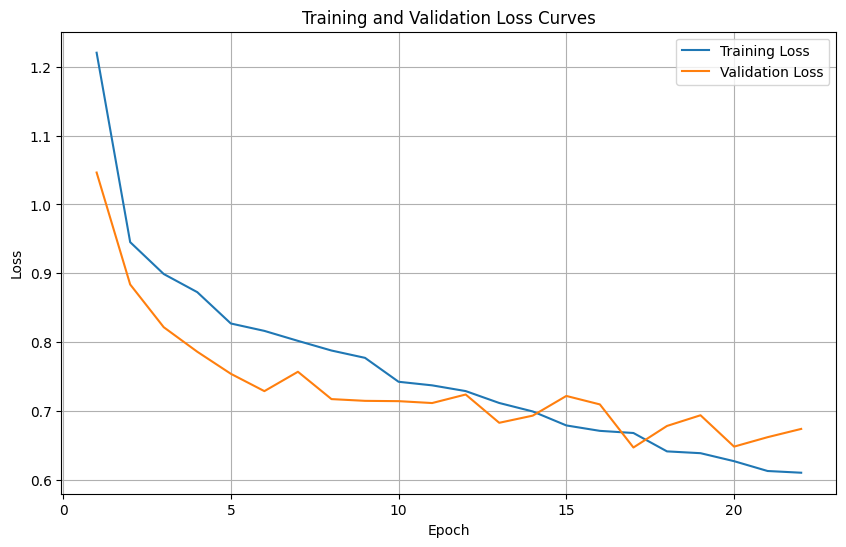

In [16]:
# plotting training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.savefig("loss_curves.png")
plt.show()

In [17]:
all_preds = []
all_targets = []
test_loss = 0.0

final_model.eval()
with torch.no_grad():
    for inputs, targets in FULL_TEST_LOADER:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

test_loss /= len(FULL_TEST_LOADER.dataset)
test_accuracy = np.mean(np.array(all_preds) == np.array(all_targets))

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
logging.info("Test Loss: %.4f, Test Accuracy: %.2f%%", test_loss, test_accuracy * 100)

# plot classification report
class_names = FULL_TEST_LOADER.dataset.classes
report = classification_report(all_targets, all_preds, target_names=class_names)
print("\nClassification Report:\n", report)
logging.info("Classification Report:\n%s", report)

# plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# save confusion matrix as image
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

conf_matrix_path = os.path.join("..", "models", "efficientnetb5", "confusion_matrix.png")
fig.savefig(conf_matrix_path)
plt.close(fig)

logging.info("Confusion matrix saved to: %s", conf_matrix_path)

Test Loss: 0.6540, Test Accuracy: 73.95%

Classification Report:
               precision    recall  f1-score   support

       angry       0.84      0.69      0.76       140
       happy       0.68      0.89      0.77       148
     relaxed       0.68      0.60      0.64       146
         sad       0.80      0.78      0.79       138

    accuracy                           0.74       572
   macro avg       0.75      0.74      0.74       572
weighted avg       0.75      0.74      0.74       572

